In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
signal_df = pd.read_parquet("train/data/signal_data.parquet")
background_df = pd.read_parquet("train/data/background_data.parquet")

In [ ]:
def extract(dframe, key):
    return dframe[0][key]

In [ ]:
signal_fatjets = signal_df['FatJets']

In [ ]:
background_fatjets = background_df['FatJets']

In [ ]:
keys = list(signal_fatjets[0][0].keys())

In [ ]:
signal_key_vals = {}
for i in keys:
    signal_key_vals[i] = signal_fatjets.apply(lambda x: extract(x, i)).values.tolist()

In [ ]:
background_key_vals = {}
for i in keys:
    background_key_vals[i] = background_fatjets.apply(lambda x: extract(x, i)).values.tolist()

In [10]:
step_sig = pd.DataFrame.from_dict(signal_key_vals)

In [11]:
step_bkg = pd.DataFrame.from_dict(background_key_vals)

In [12]:
items = ['area', 'eta', 'mass','msoftdrop', 'n2b1', 'n3b1', 'phi', 'pt']

In [13]:
small_sig = step_sig[items]

In [14]:
small_bkg = step_bkg[items]

In [15]:
small_sig.shape

(1940, 8)

In [16]:
small_bkg.shape

(20264, 8)

In [17]:
sig_arr = small_sig.to_numpy(dtype=float)
bkg_arr = small_bkg.to_numpy(dtype=float)

In [18]:
sig_arr.shape, bkg_arr.shape

((1940, 8), (20264, 8))

In [19]:
comb = np.concatenate((sig_arr, bkg_arr))

In [20]:
comb.shape

(22204, 8)

In [21]:
fatjet_tensor = torch.from_numpy(comb).type(torch.float)

In [22]:
fatjet_tensor.shape

torch.Size([22204, 8])

In [23]:
sig_labels = torch.zeros(1940)
bkg_labels = torch.ones(20264)

In [24]:
label_tensor = torch.concatenate((sig_labels, bkg_labels)).type(torch.LongTensor)

In [25]:
label_tensor.shape

torch.Size([22204])

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fatjet_tensor,
    label_tensor,
    test_size=0.2,
    random_state=42,

)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([17763, 8]),
 torch.Size([4441, 8]),
 torch.Size([17763]),
 torch.Size([4441]))

In [28]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, width=256):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [30]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

torch.float32 torch.float32 torch.int64 torch.int64


In [31]:
# Print out untrained model outputs
print("Logits:")
print(model(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model(X_train)[:10], dim=1).argmax(dim=1))

Logits:
tensor([[10.5433,  7.2174],
        [ 5.7327,  6.6618],
        [14.5509,  3.8035],
        [20.2516,  3.9309],
        [ 6.8364,  8.1588],
        [ 8.4321,  7.5902],
        [10.8001,  4.0935],
        [11.8726,  5.5622],
        [ 7.3370,  6.3747],
        [ 9.4161,  6.5501]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred probs:
tensor([[9.6531e-01, 3.4693e-02],
        [2.8310e-01, 7.1690e-01],
        [9.9998e-01, 2.1501e-05],
        [1.0000e+00, 8.1661e-08],
        [2.1042e-01, 7.8958e-01],
        [6.9885e-01, 3.0115e-01],
        [9.9878e-01, 1.2213e-03],
        [9.9819e-01, 1.8140e-03],
        [7.2357e-01, 2.7643e-01],
        [9.4614e-01, 5.3857e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


In [32]:
torch.manual_seed(42)
epochs = 45
losses, test_losses = [], []

for epoch in range(epochs):
    batch_loss, val_batch_loss = [], []
    model.train()
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    batch_loss.append(loss.item())

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        val_batch_loss.append(test_loss.item())
    losses.append(np.mean(batch_loss))
    test_losses.append(np.mean(val_batch_loss))
        
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Test Loss: {test_loss:.2f}")

Epoch: 0 | Loss: 156.39 | Test Loss: 2123.41
Epoch: 5 | Loss: 19.48 | Test Loss: 8.56
Epoch: 10 | Loss: 0.42 | Test Loss: 4.37
Epoch: 15 | Loss: 7.02 | Test Loss: 4.89
Epoch: 20 | Loss: 2.42 | Test Loss: 1.68
Epoch: 25 | Loss: 0.76 | Test Loss: 0.50
Epoch: 30 | Loss: 0.32 | Test Loss: 0.28
Epoch: 35 | Loss: 0.28 | Test Loss: 0.25
Epoch: 40 | Loss: 0.27 | Test Loss: 0.24


Text(0, 0.5, 'loss')

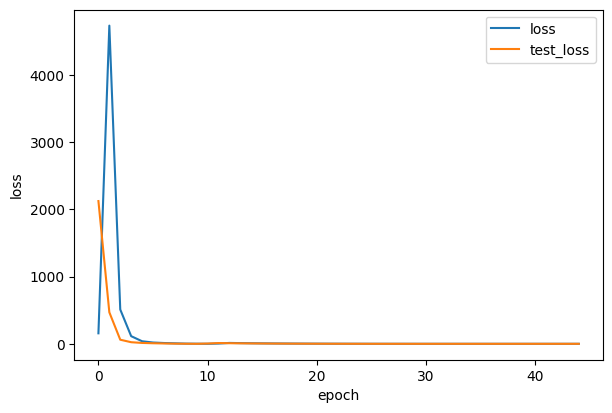

In [33]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
ax.plot(losses, label="loss")
ax.plot(test_losses, label="test_loss")
ax.legend(loc="upper right")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

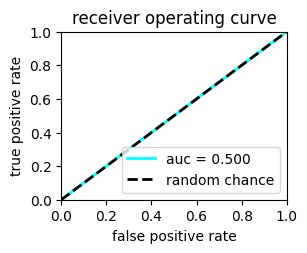

In [34]:
with torch.inference_mode():
    y_logits = model(X_test)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, thresholds = roc_curve(y_test.cpu(), 
                                     y_pred.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    plt.show()

In [35]:
y_test

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [36]:
len(torch.where(y_pred == 1)[0])

4441

In [37]:
y_pred

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')